In [5]:
%reload_ext autoreload
%autoreload 2

import rdkit
rdkit.Chem.Draw.IPythonConsole.ipython_maxProperties = -1

import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/out/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

Working on new docking oracles.

In [245]:
from dgym.envs.oracle import DockingOracle, NeuralOracle
from dgym.envs.utility import ClassicUtilityFunction

config = {
    'center_x': 9.812,
    'center_y': -0.257,
    'center_z': 20.8485,
    'size_x': 14.328,
    'size_y': 8.85,
    'size_z': 12.539,
    'exhaustiveness': 128,
    'max_step': 20,
    'num_modes': 9,
    'scoring': 'vinardo',
    'refine_step': 3,
    'seed': 5
}

docking_oracle = DockingOracle(
    'Mpro affinity',
    receptor_path='../../dgym-data/Mpro_prepped.pdbqt',
    config=config
)

neural_oracle = NeuralOracle(
    'Mpro affinity',
    state_dict_path='../../dgym-data/neural/asapdiscovery-SARS-CoV-2-Mpro-GAT-2023.08.25.th'
)

# create evaluators
docking_utility = ClassicUtilityFunction(
    neural_oracle,
    ideal=(10.5, 10_000),
    acceptable=(6, 10_000)
)

Create selection loop.

In [246]:
from tqdm.notebook import tqdm

class Experiment:
    
    def __init__(self, drug_agent, drug_env):
        
        self.drug_agent = drug_agent
        self.drug_env = drug_env
    
    def run(self, num_trials, progress=False):
        
        results = []
        for trial in tqdm(range(num_trials)):

            observations, info = drug_env.reset()

            if progress:
                pbar = tqdm(total = drug_env.budget)
            
            while True:
                action = drug_agent.act(observations)
                observations, _, terminated, truncated, _ = drug_env.step(action)
                try:
                    print(np.nanmax(observations.annotations['Mpro affinity']))
                except:
                    pass
                
                if progress:
                    pbar.n = len(drug_env.library.annotated)
                    pbar.update()
                
                if terminated or truncated:
                    break

            result = {
                'trial': trial,
                **vars(drug_agent)
            }

            if terminated:
                cost = len(drug_env.library.annotated)
                result.update({'cost': cost, 'outcome': 1})

            if truncated:
                result.update({'outcome': 0})

            results.append(result)

        return results

Run experiment.

In [270]:
import numpy as np
best = np.argsort(docking_utility.oracle(deck))[-10:]
best_molecules = [d for d in deck[best] if len(d.reactants) == 2]

In [321]:
from dgym.molecule import Molecule
from dgym.envs.designer import Designer, Generator
from dgym.envs.drug_env import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

designer = Designer(
    Generator(building_blocks, fingerprints),
    reactions,
    cache = True
)

drug_env = DrugEnv(
    designer,
    library = dg.collection.MoleculeCollection(best_molecules[-1:]).update_annotations(),
    # library = dg.collection.MoleculeCollection([drug_env.library.annotated[0]]),
    assays = [docking_utility.oracle],
    budget = 100,
    utility_function = docking_utility,
)

sequence = [
    {'name': 'ideate', 'parameters': {'temperature': 0.1, 'size': 30, 'strict': False}},
    {'name': 'Mpro affinity'},
    {'name': 'ideate', 'parameters': {'temperature': 0.0, 'size': 30, 'strict': True}},
    {'name': 'Mpro affinity'},
]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    utility_function = docking_utility,
    exploration_strategy = EpsilonGreedy(epsilon = 0.0),
    branch_factor = 5
)

experiment = Experiment(drug_agent, drug_env)
result = experiment.run(1, progress=True)

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

[0]
[2, 25, 9, 14, 21]
7.118471622467041
[2, 25, 9, 14, 21]
7.118471622467041
[31, 70, 69, 48, 63]
7.9133381843566895
[31, 70, 69, 48, 63]
7.9133381843566895
[31, 127, 125, 213, 86]
7.9133381843566895
[31, 127, 125, 213, 86]
7.9133381843566895
[31, 230, 127, 234, 125]
7.9133381843566895
[31, 230, 127, 234, 125]
7.9133381843566895
[269, 31, 360, 350, 230]
8.009486198425293
[269, 31, 360, 350, 230]
8.009486198425293
[269, 31, 396, 360, 350]
8.009486198425293
[269, 31, 396, 360, 350]
8.009486198425293
[406, 269, 31, 396, 360]
8.029446601867676
[406, 269, 31, 396, 360]
8.029446601867676
[551, 406, 269, 31, 396]
8.590636253356934
[551, 406, 269, 31, 396]
8.590636253356934
[551, 553, 554, 559, 569]
8.590636253356934
[551, 553, 554, 559, 569]
8.590636253356934
[551, 553, 554, 559, 569]
8.590636253356934
[551, 553, 554, 559, 569]
8.590636253356934
[551, 553, 554, 559, 741]
8.590636253356934
[551, 553, 554, 559, 741]
8.590636253356934
[551, 553, 554, 559, 741]
8.590636253356934
[551, 553, 554, 

KeyboardInterrupt: 

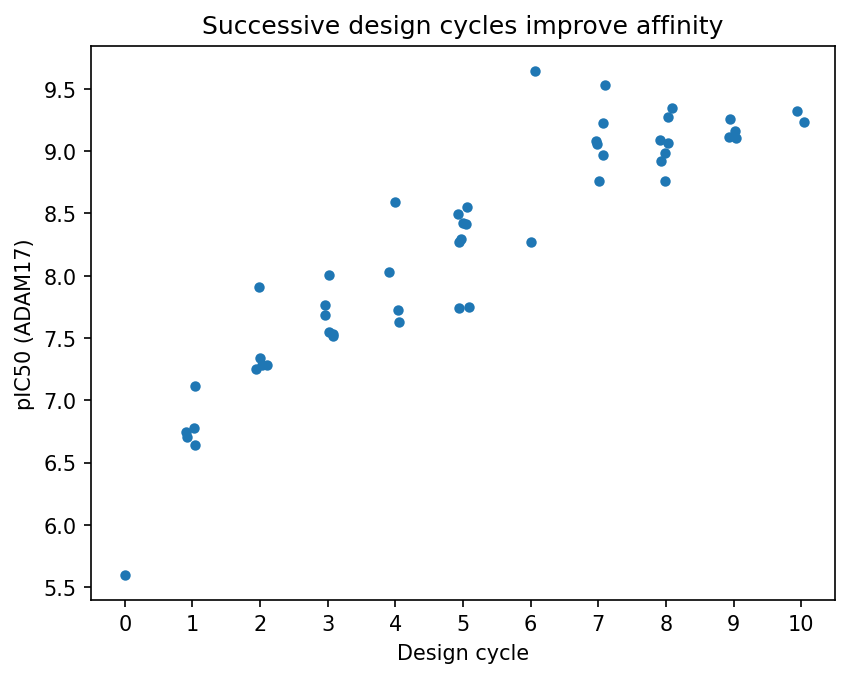

In [322]:
import matplotlib.pyplot as plt
import seaborn as sns

annotated_molecules = drug_env.library.annotated
g = sns.stripplot(
    x = [a.design_cycle for a in annotated_molecules],
    y = docking_utility.oracle(annotated_molecules),
)

g.set_title('Successive design cycles improve affinity')
g.set_xlabel('Design cycle')
g.set_ylabel('pIC50 (ADAM17)')

plt.gcf().set_dpi(150)
plt.show()

In [323]:
drug_env.library

MoleculeCollection with 4580 Molecules

In [324]:
docking_utility.oracle([annotated_molecules[-1]])

[9.277785301208496]

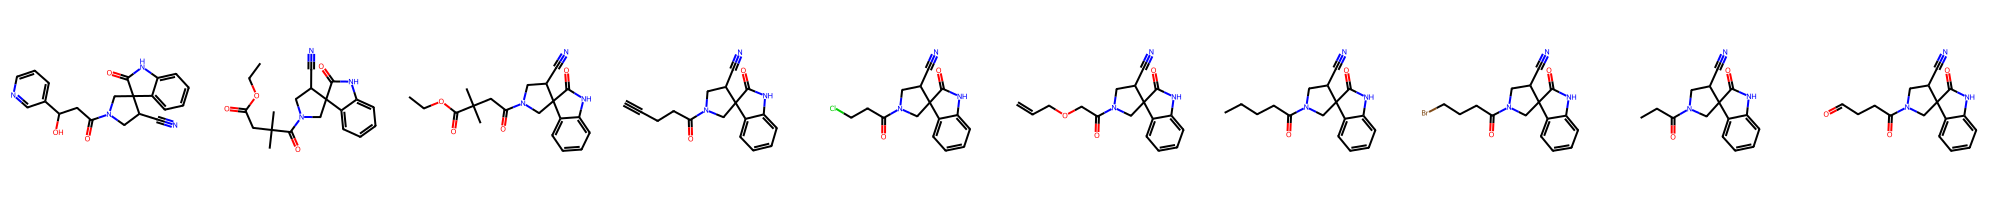

In [331]:
prods = designer.design(annotated_molecules[-1], 10)

from rdkit.Chem.Draw import MolsToGridImage
MolsToGridImage([p.mol for p in prods], molsPerRow=10)

In [352]:
docking_utility.oracle(designer.design(annotated_molecules[-1], 10))

[7.83921480178833,
 6.806192874908447,
 5.127965450286865,
 6.874439716339111,
 5.192460536956787,
 5.340721607208252,
 5.410995960235596,
 6.143824100494385,
 5.733839511871338,
 4.901170253753662]